In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from itertools import combinations
from scipy.spatial import cKDTree
from IPython.display import display
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['grey', 'red'])
from sklearn.cluster import DBSCAN
import cv2
import networkx as nx
from collections import Counter
import random
import matplotlib
import matplotlib.colors as mcolors

DATA_PATH = "/home/kartik/layout-analysis/stress-test-data"
SAMPLE_SIZE = 6  #number of pages to process
GRAPH_DATA_PATH = "/home/kartik/layout-analysis/graph-data/"



In [12]:

NUM_NEIGHBOURS = 8
norm_ratio_threshold = 2  # Allows a max ratio of 1.5 between the norms
cos_similarity_less_than = -0.8
# we assume that character spacing is less than line spacing 


%matplotlib widget


In [13]:


def cluster_with_single_majority(to_cluster, eps=3, min_samples=2):
    """
    Clusters data, identifying only one majority cluster and marking all other points as outliers.

    Args:
        to_cluster: List of data points to cluster.
        eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        NumPy array of labels, where the majority cluster is labeled 0, and all other points are labeled -1.
    """
    to_cluster_array = np.array(to_cluster)

    if len(to_cluster_array) == 0:
      return np.array([])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(to_cluster_array)

    # Count the occurrences of each label
    label_counts = Counter(labels)

    # Find the majority cluster label (excluding -1 outliers)
    majority_label = None
    max_count = 0
    for label, count in label_counts.items():
        if label != -1 and count > max_count:
            majority_label = label
            max_count = count

    # Create a new label array where the majority cluster is 0 and all others are -1
    new_labels = np.full(len(labels), -1)  # Initialize all as outliers

    if majority_label is not None:
        new_labels[labels == majority_label] = 0  # Assign 0 to the majority cluster

    return new_labels

def convert_to_graph(to_plot, points):
    # Create an empty graph
    G = nx.Graph()
    
    # Add all points as nodes with their coordinates as features
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    
    # Add edges from to_plot, avoiding duplicates (NetworkX handles this automatically)
    for center, neighbor1, neighbor2 in to_plot:
        G.add_edge(center, neighbor1)
        G.add_edge(center, neighbor2)
    
    # Create adjacency matrix
    adj_matrix = nx.to_numpy_array(G)
    
    # Create feature matrix (each row contains the x,y coordinates of a point)
    feature_matrix = np.array([G.nodes[i]['pos'] for i in range(len(points))])
    
    return G, adj_matrix, feature_matrix

In [14]:
pg_no = 0


Processing file: /home/kartik/layout-analysis/stress-test-data/3.txt


/tmp/ipykernel_3248162/3830047099.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = plt.cm.get_cmap('tab10', max(num_clusters, 3))


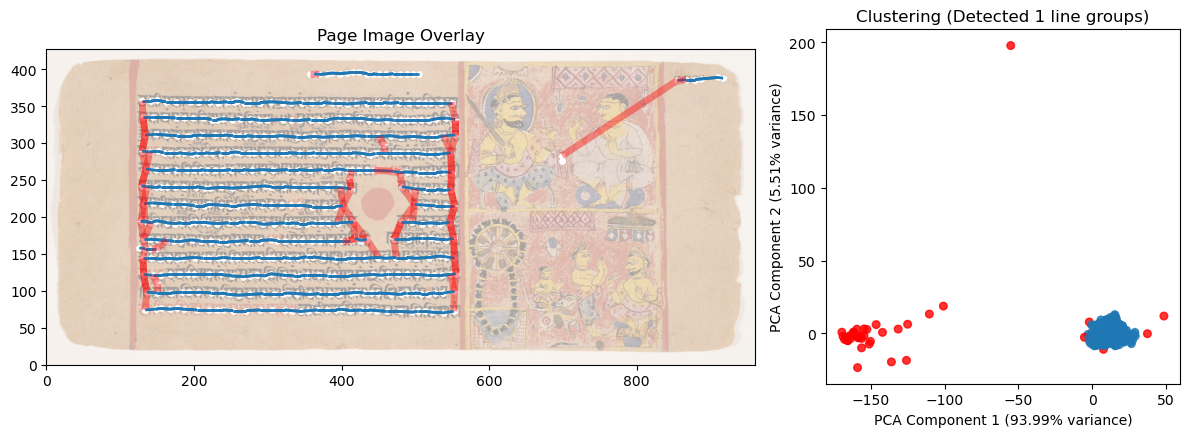

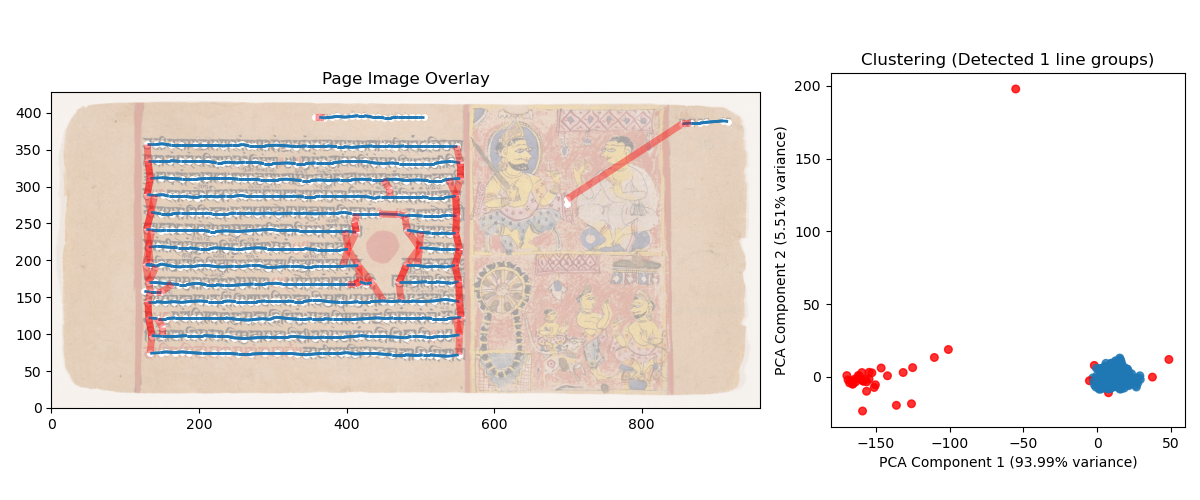

In [18]:
# Get unique prefixes efficiently without sorting everything
for entry in os.scandir(DATA_PATH):
    # if entry.is_file() and entry.name.endswith(f'{pg_no}.txt'):
    if entry.is_file() and entry.name == f'{pg_no}.txt':

        bg_img = plt.imread(DATA_PATH+f"/{pg_no}.jpg")  # Replace with your image path
        bg_img = cv2.resize(bg_img, (bg_img.shape[1] // 2, bg_img.shape[0] // 2))
        height, width = bg_img.shape[:2]

        points_file = entry.path
        print(f"Processing file: {points_file}")
        points = np.loadtxt(points_file)
        
        # Build a KD-tree for fast neighbor lookup
        tree = cKDTree(points)
        _, indices = tree.query(points, k=NUM_NEIGHBOURS)
        
        segments = []
        seg_colors = [] 

        to_cluster = []
        to_plot = []

        # Process nearest neighbors
        for current_point_index, nbr_indices in enumerate(indices):
            normalized_points = points[nbr_indices] - points[current_point_index]
            scaling_factor = np.max(np.abs(normalized_points))
            if scaling_factor == 0:
                scaling_factor = 1
            scaled_points = normalized_points / scaling_factor
            relative_neighbours = [(global_idx, sp, np)
                                   for global_idx, sp, np in zip(nbr_indices, scaled_points, normalized_points)]
            

            filtered_neighbours = []
            for _a, _b in combinations(relative_neighbours, 2):
                # calculate the angle between the two pair vectors
                if np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]) == 0:
                    cos_similarity = 0.0
                else:
                    cos_similarity = np.dot(_a[1], _b[1]) / (np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]))

                # calculate the non-normalized length of the pair
                norm1 = np.linalg.norm(_a[2])
                norm2 = np.linalg.norm(_b[2])
                total_length = norm1 + norm2

                # select pairs who have an angle of around 180 degrees between them
                if cos_similarity < cos_similarity_less_than:
                    filtered_neighbours.append((_a, _b, total_length, cos_similarity))

            if filtered_neighbours:
                # select the pair with the shortest total_length (sometimes, the 2nd shortest is the right answer)
                shortest_pair = min(filtered_neighbours, key=lambda x: x[2])

                _connection_1, _connection_2, total_length, cos_similarity = shortest_pair
                global_idx_connection_1 = _connection_1[0]
                global_idx_connection_2 = _connection_2[0]

                # calculate the angles made with the X-axis for clustering purpose
                theta_a = np.degrees(np.arctan2(_connection_1[2][1], _connection_1[2][0]))
                theta_b = np.degrees(np.arctan2(_connection_2[2][1], _connection_2[2][0]))
                theta = (theta_a,theta_b)
                
                to_plot.append((current_point_index, global_idx_connection_1, global_idx_connection_2))
                
                # Add new informative features for improved clustering
                y_diff1 = abs(_connection_1[2][1])  # Vertical distance component
                y_diff2 = abs(_connection_2[2][1])
                avg_y_diff = (y_diff1 + y_diff2) / 2
                
                x_diff1 = abs(_connection_1[2][0])  # Horizontal distance component
                x_diff2 = abs(_connection_2[2][0])
                avg_x_diff = (x_diff1 + x_diff2) / 2
                
                # Calculate aspect ratio of the connection (height/width)
                aspect_ratio = avg_y_diff / max(avg_x_diff, 0.001)  # Avoid division by zero
                
                # Calculate vertical alignment consistency (low value = better alignment)
                vert_consistency = abs(y_diff1 - y_diff2)
                
                to_cluster.append((
                    total_length, 
                    np.abs(theta[0]+theta[1]),
                    aspect_ratio,
                    vert_consistency,
                    avg_y_diff  # Vertical distance is important for line detection
                ))


        to_cluster_array = np.array(to_cluster)  # Convert list to NumPy array
        labels = cluster_with_single_majority(to_cluster)
        
        # Get the number of clusters (excluding noise points labeled as -1)
        unique_labels = np.unique(labels)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        # Create a colormap with distinct colors for each cluster
        # Use a distinct color for outliers (-1)
        colors_map = plt.cm.get_cmap('tab10', max(num_clusters, 3))
        colors = np.zeros(len(to_cluster), dtype=object)
        
        # Assign colors to each cluster
        for i, label in enumerate(labels):
            if label == -1:  # Outliers
                colors[i] = 'red'
            else:
                # Convert numerical color to hex string for consistency
                rgba = colors_map(label % 10)  # Cycle through 10 distinct colors
                colors[i] = matplotlib.colors.rgb2hex(rgba)
        
        # Adjust figure layout: large left panel for nearest neighbors, smaller right panel for scatter plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), 
                                       gridspec_kw={'width_ratios': [2, 1]})  # Left panel is twice the width
        ax2.set_box_aspect(1)  
        
        # Dictionary to store segment colors for graph creation
        edge_colors = {}
        
        for i, s in enumerate(to_plot):
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            segments.extend([seg1, seg2])
            
            # Use the cluster color for the segments
            segment_color = colors[i]
            seg_colors.extend([segment_color, segment_color])
            
            # Store edge labels for graph creation
            # -1 = outlier/no link (red), other values = specific cluster
            label_value = labels[i]
            
            # Store in edge_colors dictionary for graph creation if needed
            edge_colors[(s[0], s[1])] = label_value
            edge_colors[(s[0], s[2])] = label_value

        # Create a single figure for displaying the final results
        # Don't show the plot here since we'll display the interactive figure later
        plt.close()  # Close any previous figures to avoid duplicates
        
        # Create a new figure for the final visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), 
                                      gridspec_kw={'width_ratios': [2, 1]})
        ax2.set_box_aspect(1)
        
        # Display the background image
        ax1.imshow(bg_img, alpha=0.4, zorder=0, extent=[0, width, 0, height])
        ax1.set_xlim(0, width)
        ax1.set_ylim(0, height) 
        # Define linewidths based on seg_colors
        colors_rgba = []
        for c in seg_colors:
            if c == 'red':
                # Set red color with alpha 0.4
                colors_rgba.append((1.0, 0.0, 0.0, 0.4))
            else:
                # Convert the color name to an RGBA tuple (alpha defaults to 1.0)
                colors_rgba.append(mcolors.to_rgba(c))

        # Define linewidths: 5 for red, 2 otherwise
        linewidths = np.where(np.array(seg_colors) == 'red', 5, 2)
        base_lc = mc.LineCollection(segments, linewidths=linewidths, colors=colors_rgba)

        ax1.add_collection(base_lc)
        ax1.scatter(points[:, 0], points[:, 1], c='white', s=15)
        ax1.set_title("Page Image Overlay")

        # Run PCA to visualize the clustering in 2D when we have more than 2 features
        from sklearn.decomposition import PCA
        
        # Only apply PCA if we have more than 2 features
        if to_cluster_array.shape[1] > 2:
            pca = PCA(n_components=2)
            reduced_features = pca.fit_transform(to_cluster_array)
            feature_x = reduced_features[:, 0]
            feature_y = reduced_features[:, 1]
            ax2.set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            ax2.set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        else:
            # If only 2 features, use them directly
            feature_x, feature_y = zip(*to_cluster) if to_cluster else ([], [])
            ax2.set_xlabel('Length')
            ax2.set_ylabel('Angle with X-axis')
        
        # Create the scatter plot with the clusters
        scatter = ax2.scatter(feature_x, feature_y, c=colors, s=30, alpha=0.8, picker=True)
        ax2.set_title(f'Clustering (Detected {num_clusters} line groups)')
        

        # Interactive Highlighting
        highlighted_segments = [None]

        def on_pick(event):
            if event.artist != scatter:
                return
            if len(event.ind) == 0:
                return

            i = event.ind[0]
            s = to_plot[i]
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            
            if highlighted_segments[0] is not None:
                highlighted_segments[0].remove()
                highlighted_segments[0] = None

            highlighted_segments[0] = mc.LineCollection([seg1, seg2], linewidths=6, colors='yellow', alpha=0.8)
            ax1.add_collection(highlighted_segments[0])
            

            
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('pick_event', on_pick)

        # Display the interactive figure
        plt.tight_layout()
        display(fig)
        

pg_no+=1